# Importing Libraries

In [21]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Loading data

In [22]:
# Load the dataset from the specified location
data = pd.read_csv('creditcard.csv')

# Exploratory Analysis

Sample data
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V2

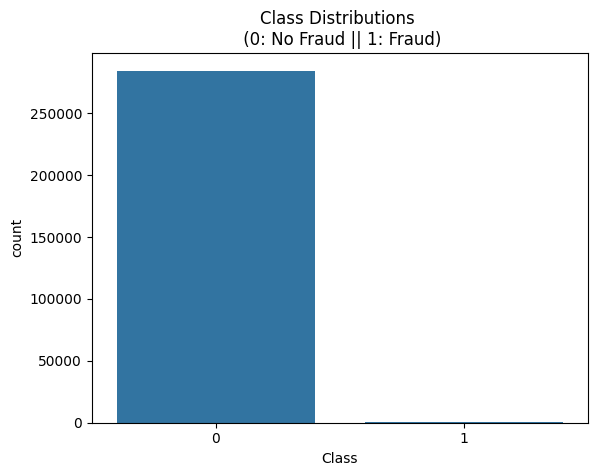

In [23]:
# Display basic information and summary statistics
print("Sample data")
print(data.head())
print("====================================================================================")
print("Summary Statistics")
print(data.describe())
print("====================================================================================")
print("Missing value check")
# Check for missing values
print(data.isnull().sum())
print("====================================================================================")
print("distribution of Class")
# Plotting the distribution of the 'Class' to see the data imbalance
sns.countplot(x='Class', data=data)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)')
plt.show()


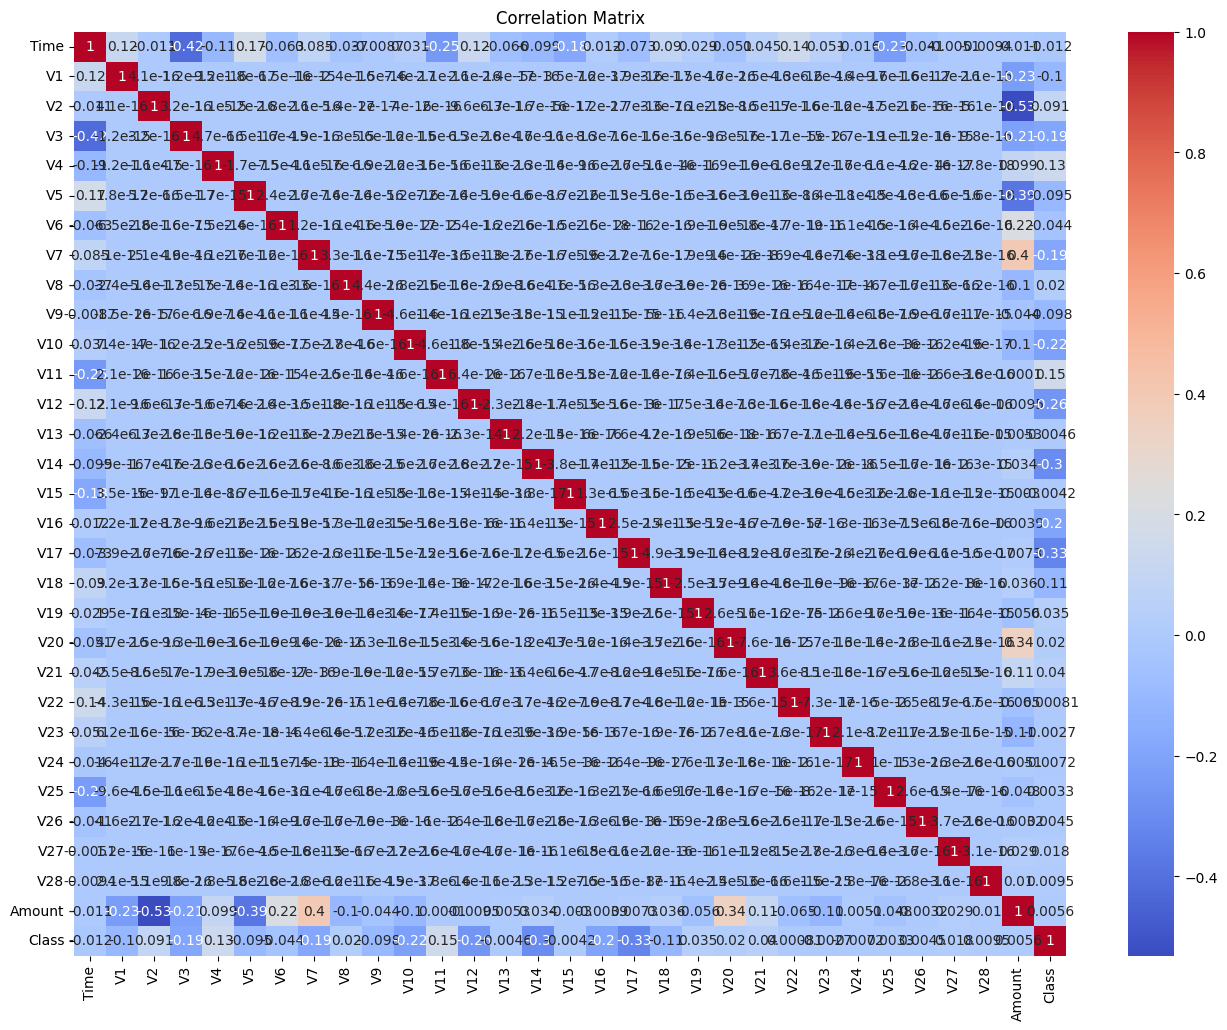

In [24]:
correlation_matrix = data.corr()
# Increase the size of the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Results:

**Based on the exploratory analysis the following Preprocessing will be implemented:**

* **Handling Missing Values:** Investigate and impute or remove missing values in V22 to V28 and Amount.
* **Feature Scaling:** The 'Amount' variable significantly varies in scale compared to principal component features.
* **Outlier Detection and Handling:** Assess the impact of extreme values in features, especially in the Amount and principal components, to decide on capping, transformation, or removal.
* **Dealing with Class Imbalance:** Techniques like SMOTE, undersampling the majority class, or using anomaly detection methods could be considered to improve model performance on minority class predictions.

# Data Pre-processing

## Impute Missing Values Using Median

In [25]:
# List of columns to impute
columns_to_impute = ['V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Impute missing values using median for each column
for column in columns_to_impute:
    median_value = data[column].median()
    data[column].fillna(median_value, inplace=True)

In [26]:
# Check if there are any missing values remaining in the specified columns
missing_values_after = data[columns_to_impute].isnull().sum()
print("Missing values in each column after imputation:\n", missing_values_after)

Missing values in each column after imputation:
 V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64


## Feature Scaling

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the 'Amount' column
# The scaler expects an array-like object, hence the use of double brackets
data['Amount_Scaled'] = scaler.fit_transform(data[['Amount']])

# Display the first few rows to verify scaling
print(data[['Amount', 'Amount_Scaled']].head())

# Drop the Original 'Amount' Column
data.drop('Amount', axis=1, inplace=True)


   Amount  Amount_Scaled
0  149.62       0.244964
1    2.69      -0.342475
2  378.66       1.160686
3  123.50       0.140534
4   69.99      -0.073403


## Outlier Handling

In [28]:
# define a function to handle outliers using the IQR for capping. Outliers will be capped at the 1st and 99th percentiles.
def cap_outliers(series, lower_percentile=1, upper_percentile=99):
    """ Cap values in a pandas series at the 1st and 99th percentiles """
    quantile_one = series.quantile(lower_percentile/100.0)
    quantile_ninety_nine = series.quantile(upper_percentile/100.0)
    series_capped = np.where(series < quantile_one, quantile_one,
                             np.where(series > quantile_ninety_nine, quantile_ninety_nine, series))
    return series_capped

# Apply Outlier Capping to 'Amount' and Principal Components
principal_components = ['V' + str(i) for i in range(1, 29)]
data['Amount_Scaled'] = cap_outliers(data['Amount_Scaled'])

for component in principal_components:
    data[component] = cap_outliers(data[component])


# Check the Effect of Capping
print(data[['Amount_Scaled'] + principal_components].describe())

       Amount_Scaled             V1             V2             V3  \
count  284807.000000  284807.000000  284807.000000  284807.000000   
mean       -0.032610       0.038150       0.022670       0.021939   
std         0.636832       1.712310       1.275830       1.370562   
min        -0.352750      -6.563199      -4.960300      -3.978377   
25%        -0.330840      -0.920373      -0.598550      -0.890365   
50%        -0.265271       0.018109       0.065486       0.179846   
75%        -0.044717       1.315642       0.803724       1.027196   
max         3.716702       2.237130       3.801811       2.728434   

                  V4             V5             V6             V7  \
count  284807.000000  284807.000000  284807.000000  284807.000000   
mean       -0.003695       0.007724       0.003972       0.004114   
std         1.370351       1.129985       1.237162       0.909037   
min        -3.122987      -3.060396      -2.124023      -3.012847   
25%        -0.848640      -0.6915

In [29]:
data.drop_duplicates(inplace=True)

# Splitting the dataset into training and testing sets

In [31]:
# Splitting the dataset into training and testing sets
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Dealing with Class Imbalance

SMOTE (Synthetic Minority Over-sampling Technique)

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=123)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creating Models

In [33]:
# Using Logistic Regression for the baseline model
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

# Fine-tuning

# Evaluating the model

[[56647     9]
 [   27    63]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.88      0.70      0.78        90

    accuracy                           1.00     56746
   macro avg       0.94      0.85      0.89     56746
weighted avg       1.00      1.00      1.00     56746



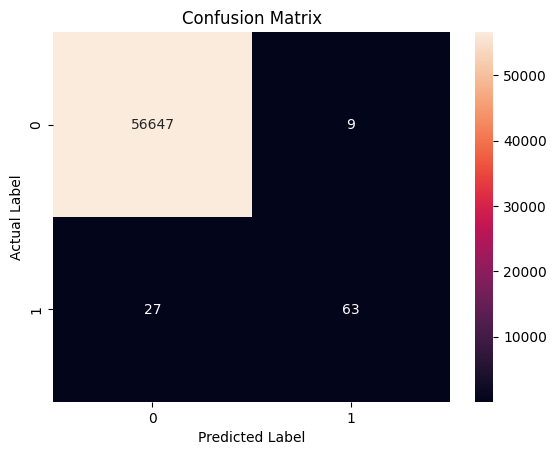

In [34]:
# Evaluating the model
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plotting confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Conclusion


While the model shows excellent performance in identifying non-fraudulent transactions with high accuracy and precision, the recall for fraudulent transactions at 0.70 suggests that there is significant room for improvement.